In [506]:
colab = True
if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    import os
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 1')

fatal: destination path 'PUC_Redes_Neurais' already exists and is not an empty directory.


# **Redes Neurais**
## **1ª Lista de Exercícios - Classificação de padrões**


**Estudante:** Ana Arai

**Base de dados:** c_diabetes.csv

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<h1> Importante! </h1>

1. Fique atento com os hiperparâmetros iniciais desta lista. Dependendo do problema, os valores podem mudar. Para encontrar um conjunto de parâmetros razoáveis, siga o seguinte roteiro:

        1. Rode os itens 2.1 e 3.1 com os parâmetros iniciais. Se os dois resultados foram igualmente ruins, modifique os parâmetros do item 3.1 até que o resultado seja relativamente melhor que o 2.1.

        2. Após obter esses melhores parâmetros iniciais, rode novamente o item 2.1 com os mesmos hiperparâmetros para uma comparação mais justa.

2. O resultado de um modelo de Redes Neurais geralmente depende da inicialização de seus pesos. Portanto, para cada questão, obtenha um resultado médio de pelo menos 10 rodadas.

In [507]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train


In [508]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar
  o mesmo modelo com apenas uma linha.

  Parâmetros de entrada:
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida.
  - hidden_activation: Função de ativação para cada camada escondida. Aceita
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]

    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h)
    y = self.fc2(h1)
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [509]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Preparação dos dados**

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [510]:
dataset_name = 'diabetes'
dataset_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/c_{dataset_name}.csv'
info_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/data_info/{dataset_name}/data_info.json'
dataset = pd.read_csv(dataset_path)

In [511]:
resp = requests.get(info_path)
info = json.loads(resp.text)

In [512]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [513]:
for i in dataset.dtypes.items():
    print(i)

('preg', dtype('int64'))
('plas', dtype('int64'))
('pres', dtype('int64'))
('skin', dtype('int64'))
('insu', dtype('int64'))
('mass', dtype('float64'))
('pedi', dtype('float64'))
('age', dtype('int64'))
('target', dtype('O'))


## **Parte I - Compreensão do problema e análise de variáveis**

Total: 2,0 pts.


### **1.1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.**

#### **1.1.1.) Rascunho**

##### **1.1.1) Detectando e excluindo linhas com valores NA**

In [514]:
# Detect missing values
dataset.isna().sum()

preg      0
plas      0
pres      0
skin      0
insu      0
mass      0
pedi      0
age       0
target    0
dtype: int64

In [515]:
# Delete row with missing values
dataset=dataset.dropna()
dataset

,preg,plas,pres,skin,insu,mass,pedi,age,target
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,tested_negative
764,2,122,70,27,0,36.8,0.340,27,tested_negative
765,5,121,72,23,112,26.2,0.245,30,tested_negative
766,1,126,60,0,0,30.1,0.349,47,tested_positive


##### **1.1.2) Análise dos gráficos das correlações das variáveis**



In [516]:
sns.pairplot(dataset, hue="target", diag_kind="hist")

Output hidden; open in https://colab.research.google.com to view.

In [517]:
# Quantidade de registros nulos
quant_zero_plas = dataset['plas'].value_counts().get(0)
quant_zero_pres = dataset['pres'].value_counts().get(0)
quant_zero_skin = dataset['skin'].value_counts().get(0)
quant_zero_insu = dataset['insu'].value_counts().get(0)
quant_zero_mass = dataset['mass'].value_counts().get(0)

print ('Registros de plas iguais a zero: %i' %quant_zero_plas)
print ('Registros de pres iguais a zero: %i' %quant_zero_pres)
print ('Registros de skin iguais a zero: %i' %quant_zero_skin)
print ('Registros de insu iguais a zero: %i' %quant_zero_insu)
print ('Registros de mass iguais a zero: %i' %quant_zero_mass)

Registros de plas iguais a zero: 5
Registros de pres iguais a zero: 35
Registros de skin iguais a zero: 227
Registros de insu iguais a zero: 374
Registros de mass iguais a zero: 11


#### **1.1.2) Resposta**

A variável 'preg' refere-se ao número de vezes que o paciente engravidou, esta informação aparentemente parece ser a que tem menos correlação com fato de o indivíduo ter ou não diabetes, porém,  no item 1.2, é possível verificar que para as pacientes que testaram positivos o número de vezes que engravidou quando comparado com as que testaram negativo.

A variável 'insu' apresenta 374 registros, 48,7% dos dados,  com valor igual a zero e a 'skin' 227 registros, 29,6% dos dados. A primeira está relacionada a insulina e a segunda com a taxa de gordura do paciente. Esses valores serem iguais a zero podem indicar um possível erro no registro desses valores.
Outras variáveis também apresentam registros iguais a zero, tais como: 'plas' com 5 registros; 'pres' com 35; 'mass' com 11. A 'plas' refere-se a glicose e apresentam poucos registros nulos, a 'mass' trata do índice de massa corporal (IMC), não parecendo adequado um indíviduo possuir massa nula e o 'pres' é referente a pressão sanguínea diastólica, assim um valor nulo de pressão de um ser humano não indica um valor típico.

A 'plas'é o dado que apresenta, visualmente, uma melhor divisão dos testes positivos e negativos.

Apesar das observações relatadas, estes dados são da área de medicina. Desta forma, uma análise mais profunda sobre o intervalo adequado dos dados é de difícil de ser feita.

Pelos comentários acima, é possível notar que os dados nulos de 'skin' e 'insu' precisam ser tratados ou estas variáveis serem excluídas da base de dados. Além disso, há alguns registros nulos de 'plas', 'pres' e 'mass' que também precisam ser tratados, como, por exemplo, substituir os valores nulos pela média dos valores.

Alguns testes preliminares foram feitos e não apresentaram ganhos na acurácia do modelos, sendo assim todos os dados do dataset serão utilizados sem nenhum limpeza de dados e no último item desta lista serão testados algumas alterações no tratamento dos dados.

### **1.2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.**

#### **1.2.1.) Rascunho**

In [518]:
dataset.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [519]:
dataset.groupby(by='target').mean()

,preg,plas,pres,skin,insu,mass,pedi,age
target,,,,,,,,
tested_negative,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
tested_positive,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [520]:
dataset.groupby(by='target').median()

,preg,plas,pres,skin,insu,mass,pedi,age
target,,,,,,,,
tested_negative,2.0,107.0,70.0,21.0,39.0,30.05,0.336,27.0
tested_positive,4.0,140.0,74.0,27.0,0.0,34.25,0.449,36.0


In [521]:
dataset.groupby(by='target').std()

,preg,plas,pres,skin,insu,mass,pedi,age
target,,,,,,,,
tested_negative,3.017185,26.141200,18.063075,14.889947,98.865289,7.689855,0.299085,11.667655
tested_positive,3.741239,31.939622,21.491812,17.679711,138.689125,7.262967,0.372354,10.968254


####**1.2.2.) Resposta**

A média de todas as variáveis, para o teste positivo, é maior quando comparados com a média dos testado negativo. Assim, os dados mostram que os indivíduos com diabetes engravidaram mais vezes e possuem os índices de glicose, pressão sanguínea, taxa de gordura, insulina, IMC e idade mais elevados dos que testaram negativo para diabetes.

Ao avaliar a diferença entre os valores média e mediana das variáveis, observa-se que a amostra destas é assimétrica. Quando a média é mais elevada que a mediana, representa que os maiores valores da distribuição estão mais distantes dos valores centrais, como, por exemplo, o caso de 'preg', 'plas', 'insu', 'pedi' e 'age'. No caso contrário, quando a mediana é mais elevada que a média, representa uma maior distribuição dos valores menores da amostra da variável distantes do centro, como 'pres', 'skin' e 'mass'.

A variável 'insu' que, no item 1.1.2, apresenta quase metade da amostra com registros nulos, e quando analisado a mediana dos testes positivos é igual a zero, assim mostrando algum inconsistência nos dados. Além disso, verifica-se que o desvio padrão de 'insu' para teste positivo é maior que a média, mostrando uma grande dispersão desses dados.

## **Parte II. Treinamento do modelo de Rede Neural - Baseline**

Total: 1,0 pts.

### **2.1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural *sem normalizar* os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)**

#### **2.1.1) Rascunho**

In [522]:
new_df = transform_data(dataset, normalize=False)

In [523]:
new_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,target
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [524]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [525]:
batch_size = 32

In [526]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [527]:
#Para o caso de múltiplas classes
#train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
#test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

#Para o caso binário
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [528]:
train_dataset.X_data

tensor([[  3.0000, 128.0000,  78.0000,  ...,  21.1000,   0.2680,  55.0000],
        [  4.0000,  95.0000,  60.0000,  ...,  35.4000,   0.2840,  28.0000],
        [  1.0000, 163.0000,  72.0000,  ...,  39.0000,   1.2220,  33.0000],
        ...,
        [  2.0000,  90.0000,  68.0000,  ...,  38.2000,   0.5030,  27.0000],
        [  5.0000, 116.0000,  74.0000,  ...,  32.3000,   0.6600,  35.0000],
        [  4.0000, 116.0000,  72.0000,  ...,  22.1000,   0.4630,  37.0000]])

##### **2.1.1.1) Sem normalizar - Rodada única separada**

###### **2.1.1.1.1) Definição da função para uma rodada única**

In [529]:
# Hiperparametros
epochs = 500
lr = 0.01
hidden_neurons = 4
iteration = 10

In [530]:
# Rodada unica
def single_iteration (self, epochs, lr, hidden_neurons):
    model = NeuralNetwork(hidden_neurons = hidden_neurons, n_input = n_input, n_output=n_output,output_activation='sigmoid')
    history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

    plt.plot(history['loss_train'], label='train')
    plt.plot(history['loss_val'], label='val')
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

    y_pred = model.predict(test_dataset.X_data,binary=binary)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.080 | Val Loss: 0.6656 | Train Acc: 64.1875| Val Acc: 66.0000
Epoch 002: | Train Loss: 0.678 | Val Loss: 0.6542 | Train Acc: 64.8125| Val Acc: 66.0000
Epoch 003: | Train Loss: 0.666 | Val Loss: 0.6543 | Train Acc: 64.5625| Val Acc: 66.0000
Epoch 004: | Train Loss: 0.663 | Val Loss: 0.6545 | Train Acc: 64.5625| Val Acc: 66.0000
Epoch 005: | Train Loss: 0.661 | Val Loss: 0.6546 | Train Acc: 64.5625| Val Acc: 66.0000
Epoch 006: | Train Loss: 0.659 | Val Loss: 0.6546 | Train Acc: 64.3750| Val Acc: 66.0000
Epoch 007: | Train Loss: 0.658 | Val Loss: 0.6548 | Train Acc: 64.8125| Val Acc: 66.0000
Epoch 008: | Train Loss: 0.656 | Val Loss: 0.6558 | Train Acc: 64.8125| Val Acc: 66.0000
Epoch 009: | Train Loss: 0.655 | Val Loss: 0.6575 | Train Acc: 64.8125| Val Acc: 66.0000
Epoch 010: | Train Loss: 0.654 | Val Loss: 0.6589 | Train Acc: 65.1875| Val Acc: 66.0000
Epoch 011: | Train Loss: 0.654 | Val Loss: 0.6602 | Train Acc: 65.3750| Val Acc: 66.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


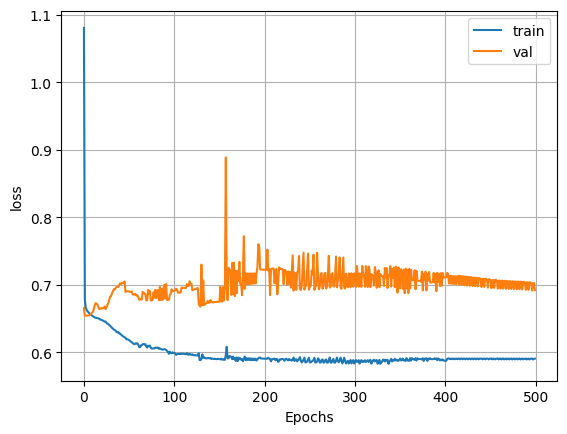

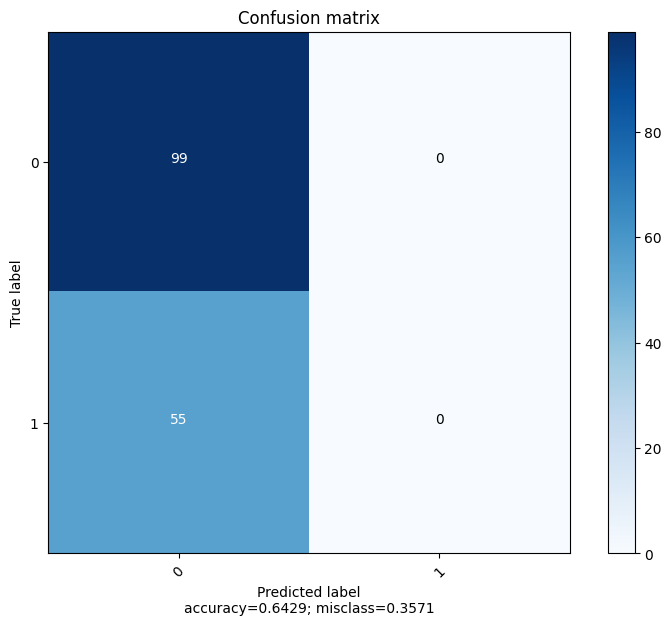

In [531]:
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

##### **2.1.1.2) Sem normalizar - 10 Rodadas para o cálculo da média**

###### **2.1.1.2.1) Função que calcula a média da acurácia, precisão, recall e F1-score para um número dado de rodadas**

In [532]:
# Funcao que calcula a media da acuracia, precisao, recall e F1-score para um numero dado de rodadas
def NN_Score_mean (self, epochs, lr, hidden_neurons, iteration):
    accuracy = []
    precision = []
    recall = []
    f1 = []

    # Variando a qtd de rodadas
    for i in range (iteration):
        model = NeuralNetwork(hidden_neurons = hidden_neurons, n_input = n_input, n_output=n_output,output_activation='sigmoid')
        history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
        y_pred = model.predict(test_dataset.X_data, binary=binary)

        accuracy.append (accuracy_score (y_test, y_pred))
        precision.append (precision_score (y_test, y_pred))
        recall.append (recall_score (y_test, y_pred))
        f1.append (f1_score (y_test, y_pred))

        print ('RODADAS Nº %i' %(i+1))
        print ('Acuracia: %.2f'  % accuracy[i])
        print ('Precisao para teste positivo: %.2f' %precision[i])
        print ('Recall para teste positivo: %.2f' %recall[i])
        print ('F1-score para teste positivo: %.2f' %f1[i])


    accuracy_mean = np.mean (accuracy)
    precision_mean  = np.mean (precision)
    recall_mean = np.mean (recall)
    f1_mean = np.mean (f1)

    # Media das rodadas
    print ('')
    print ('MEDIAS DAS %i ' % (i+1) + 'RODADAS - %i' %epochs + ' EPOCAS, %.2f' %lr + ' de taxa aprendizado e %i' %hidden_neurons + ' neuronios na camada escondida')
    print ('Media da acuracia: %.2f'  % accuracy_mean)
    print ('Media da precisao para teste positivo: %.2f'  % precision_mean)
    print ('Media do recall para teste positivo: %.2f'  % recall_mean)
    print ('Media do F1-score para teste positivo: %.2f'  % f1_mean)

    return accuracy_mean, precision_mean, recall_mean, f1_mean, iteration

In [ ]:
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.207 | Val Loss: 0.7229 | Train Acc: 56.3750| Val Acc: 67.0000
Epoch 002: | Train Loss: 0.677 | Val Loss: 0.7055 | Train Acc: 62.6875| Val Acc: 67.0000
Epoch 003: | Train Loss: 0.669 | Val Loss: 0.7091 | Train Acc: 63.1250| Val Acc: 67.0000
Epoch 004: | Train Loss: 0.662 | Val Loss: 0.7209 | Train Acc: 64.3125| Val Acc: 67.0000
Epoch 005: | Train Loss: 0.658 | Val Loss: 0.7278 | Train Acc: 63.6875| Val Acc: 67.0000
Epoch 006: | Train Loss: 0.654 | Val Loss: 0.7205 | Train Acc: 63.3125| Val Acc: 68.0000
Epoch 007: | Train Loss: 0.647 | Val Loss: 0.7213 | Train Acc: 63.3125| Val Acc: 68.0000
Epoch 008: | Train Loss: 0.643 | Val Loss: 0.7187 | Train Acc: 63.1250| Val Acc: 67.0000
Epoch 009: | Train Loss: 0.640 | Val Loss: 0.7163 | Train Acc: 65.1250| Val Acc: 67.0000
Epoch 010: | Train Loss: 0.639 | Val Loss: 0.7277 | Train Acc: 64.5000| Val Acc: 67.0000
Epoch 011: | Train Loss: 0.641 | Val Loss: 0.7465 | Train Acc: 64.6875| Val Acc: 67.0000
Epoch 012: | Train Lo

#### **2.1.2) Resposta**

##### **2.1.2.1) Função para imprimir a média das rodadas**

In [ ]:
# Funcao para imprimir a media das rodadas
def print_mean (self, epochs, iteration, accuracy_mean, precision_mean, recall_mean, f1_mean):
    print ('')
    print ('MEDIAS PARA %i ' %epochs + 'EPOCAS')
    print ('Quantidade de rodadas: %i' %iteration)
    print ('Media da acuracia: %.2f'  % accuracy_mean)
    print ('Media da precisao para teste positivo: %.2f'  % precision_mean)
    print ('Media do recall para teste positivo: %.2f'  % recall_mean)
    print ('Media do F1-score para teste positivo: %.2f'  % f1_mean)

In [ ]:
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

Os resultados sem normalização quando comparados com os normalizados, obtidos em 3.1.2. Os resultados do modelo normalizado tem um desempenho


Media da acuracia: 0.76
Media da precisao para teste positivo: 0.67
Media do recall para teste positivo: 0.66
Media do F1-score para teste positivo: 0.67

## **Parte III - Mudança de configurações do modelo**

Total: 5,0 pts.

### **3.1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.**

#### **3.1.1) Rascunho**

In [ ]:
new_df = transform_data(dataset, normalize=True)
new_df.head()

In [ ]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
# Hiperparametros
epochs = 500
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (model, epochs, lr, hidden_neurons, iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

#### **3.1.2) Resposta**

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

### **3.2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.**

#### **3.2.1).Rascunho**

##### **3.2.1.1) 1 época**

In [ ]:
# Hiperparametros
epochs = 1
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.2) 50 épocas**

In [ ]:
# Hiperparametros
epochs = 50
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.3) 100 épocas**

In [ ]:
# Hiperparametros
epochs = 100
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.4) 200 épocas**

In [ ]:
# Hiperparametros
epochs = 200
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.5) 300 épocas**

In [ ]:
# Hiperparametros
epochs = 300
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.6) 400 épocas**

In [ ]:
# Hiperparametros
epochs = 400
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.7) 500 épocas**

In [ ]:
# Hiperparametros
epochs = 500
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.8) 600 épocas**

In [ ]:
# Hiperparametros
epochs = 600
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.9) 700 épocas**

In [ ]:
# Hiperparametros
epochs = 700
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.10) 800 épocas**

In [ ]:
# Hiperparametros
epochs = 800
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.11) 900 épocas**

In [ ]:
# Hiperparametros
epochs = 900
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.2.1.12) 1000 épocas**

In [ ]:
# Hiperparametros
epochs = 1000
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

#### **3.2.2) Resposta**

Variando os valores de épocas de 1 a 1000, verificou-se que os melhores resultados de acurácia, precisão, recall e F1-score para a média de 10 rodadas.
A acurácia foi de 77%, que relaciona a quantidade de acertos em relação ao total de valores apresentados.

A Precisão positiva foi de xx%, que indica a qualidade de previsão de classificação positiva, relaciona os acertos positivos ao todos os padrões rotulados como positivos, verdadeiros e falso. Este valor é abaixo da acurácia, pois há uma maior precisão nos acertos negativos, sendo a precisão negativa, para a rodada única, de xx%.

O Recall positvo foi de xx%, que indica a qualidade de classificação do modelo em relação aos padrões que possuem rótulos reais positivos, relaciona os acertos positivos a todos padrões reais positivos. Assim é possível avaliar o desempenho do modelo quando o erro de um falso negativo pode ser prejudicial.

O F1-Score informa a média harmônica entre a Precisão e o Recall.

As três métricas, para 800 épocas, são as que possuem o maior valor e sendo os mais próximos entre eles. Assim, F1-Score, Precisão e Recall sendo quase os mesmos, pode-se inferir que há um equilíbrio entre Precisão e Recall, indicando que o modelo está fazendo previsões com consistência, desta forma sem favorecer uma métrica em detrimento da outra.

Pela matriz de confusão, é possível compreender graficamente estes resultados, observando que as predições verdeiras positivas são inferiores que as verdadeiras negativas, tanto em quantidade e percentual de cada amostra de teste. Isto, pode ter sido ocasionada pelo desiquilíbrio da quantidade das amostras positiva (55) e negativas (99).

In [ ]:
# Hiperparametros
epochs = 800
lr = 0.01
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

### **3.3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.**

#### **3.3.1) Rascunho**

##### **3.3.1.1) Taxa de aprendizado = 0,001**

In [ ]:
# Hiperparametros
epochs = 800
lr = 0.001
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.3.1.2) Taxa de aprendizado = 0,005**

In [ ]:
# Hiperparametros
epochs = 800
lr = 0.001
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.3.1.3) Taxa de aprendizado = 0,01**

In [ ]:
# Hiperparametros
epochs = 800
lr = 0.001
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.3.1.4) Taxa de aprendizado = 0,05**

In [ ]:
# Hiperparametros
epochs = 800
lr = 0.05
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

##### **3.3.1.5) Taxa de aprendizado = 0,1**

In [ ]:
# Hiperparametros
epochs = 800
lr = 0.1
hidden_neurons = 4
iteration = 10

In [ ]:
# Calculo da media das rodadas
accuracy_mean, precision_mean, recall_mean, f1_mean, iteration = NN_Score_mean (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons, iteration=iteration)

In [ ]:
# Rodada unica
single_iteration (self=model, epochs=epochs, lr=lr, hidden_neurons=hidden_neurons)

In [ ]:
# Media das rodadas
print_mean (self=model, epochs=epochs, iteration=iteration, accuracy_mean=accuracy_mean, precision_mean=precision_mean, recall_mean=recall_mean, f1_mean=f1_mean)

#### **3.3.2) Resposta**

### **3.4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.**

#### **3.4.1) Rascunho**

##### **3.4.1.1) 2 neurônios na camada escondida**

##### **3.4.1.2) 5 neurônios na camada escondida**

##### **3.4.1.3) 10 neurônios na camada escondida**

##### **3.4.1.4) 20 neurônios na camada escondida**

##### **3.4.1.5) 30 neurônios na camada escondida**

##### **3.4.1.6) 40 neurônios na camada escondida**

##### **3.4.1.7) 50 neurônios na camada escondida**

##### **3.4.1.8) 60 neurônios na camada escondida**

##### **3.4.1.9) 70 neurônios na camada escondida**

#### **3.4.2) Resposta**

## **Parte IV - Usando outras técnicas para Redes Neurais**
Total: 3,0 pts.

### **4.1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.**

OBS: para essa questão, copie a função `train` do arquivo `model_utils.py`, copie neste notebook e faça as adaptações necessárias.

#### **4.1.1) Rascunho**

In [ ]:
from tqdm.notebook import tqdm
from metrics import *
from typing import Tuple, Dict, List

def train_Early_Stopping(model: torch.nn.Module , train_loader: torch.utils.data.DataLoader,
         val_set: Tuple[torch.Tensor, torch.Tensor], epochs: int, device: torch.device,
         lr: float, binary: bool = True, skip: int = 1, patience: int = 10) -> Tuple[Dict[str, List[float]], torch.Tensor]:
    """
    Trains a Pytorch model on a given training data.

    Parameters:
    model (torch.nn.Module): The model to be trained
    train_loader (DataLoader): The training data in the form of a Pytorch DataLoader
    val_set (tuple): A tuple containing the validation data and labels
    epochs (int): The number of times the training data should be passed through the model
    device (str or torch.device): The device on which to perform the computations (e.g. 'cpu' or 'cuda')
    lr (float): The learning rate for the optimizer
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    skip (int): The number of epochs after which the training and validation results will be printed. Default: 1

    Returns:
    tuple: A tuple containing the training history and the predicted labels after training
    """


    if binary:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

    delta_loss = 0 # Diferenca entre o erro da validacao e o do treinamento
    delta_loss_prev = 0 # Diferença entre o erro da validacao e o do treinamento da ultima iteracao
    dif = 0
    cont = 0

    for e in tqdm(range(1, epochs+1)):

        y_hat = np.array([])

        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X, y = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X)

            loss = criterion(y_pred, y)
            if binary:
                acc = binary_acc(y_pred,y)
            else:
                acc = accuracy(y_pred, y)

            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            train_epoch_acc += acc.item()
            y_p = torch.argmax(y_pred, dim=1)
            y_hat = np.concatenate((y_hat, y_p))


        model.eval()
        _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

        history['acc_train'].append(train_epoch_acc/len(train_loader))
        history['loss_train'].append(train_epoch_loss/len(train_loader))
        history['acc_val'].append(val_acc)
        history['loss_val'].append(val_loss)


        # Trecho alterado
        delta_loss = abs (val_loss - train_epoch_loss/len(train_loader))
        dif = delta_loss - delta_loss_prev
        print (cont, delta_loss, delta_loss_prev, dif)

        if (delta_loss - delta_loss_prev) > (8.0e-5): # retestar para outros hiperparametros para lr=0.01, 5 neuros e epochs 1000 esta entre 7.0e-5 e 8.0e-5
          cont += 1
        else:
          cont = 0
        delta_loss_prev =  abs (val_loss - train_epoch_loss/len(train_loader))
        if (e%skip == 0):
            print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}')

        if (cont >= patience):
        # Fim do trecho alterado
          return history, y_hat
    return history, y_hat


def evaluate(model: torch.nn.Module, val_set: Tuple[torch.tensor, torch.tensor],
            criterion: torch.nn.Module, binary:bool =True) -> Tuple[torch.tensor, float, float]:
    """
    Evaluates a Pytorch model on a given dataset.
    Parameters:
    model (torch.nn.Module): The model to be evaluated
    data (tuple): A tuple containing the data and labels
    criterion (torch.nn.Module): The loss function to be used
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    Returns:
    tuple: A tuple containing predicted labels, loss, and accuracy
    """

    X = val_set.X_data
    y = val_set.y_data

    with torch.no_grad():
        y_pred = model(X)
    loss = criterion(y_pred, y)
    if binary:
        acc = binary_acc(y_pred, y)
    else:
        acc = accuracy(y_pred, y)
    y_pred = torch.argmax(y_pred, dim=1)

    return y_pred, loss.item(), acc.item()

In [ ]:
# Rodada unica
lr = 0.01
epochs = 1000
hidden_neurons = 5
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train_Early_Stopping (model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

plt.plot(history['loss_train'], label='train')
plt.plot(history['loss_val'], label='val')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

#### **4.1.2) Resposta**

### **4.2)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.**

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco.

#### **4.2.1) Rascunho**

In [ ]:
lr = 0.01
epochs = 800
hidden_neurons = 4
k = 10  # qtde de folds

accuracy = []
precision = []
recall = []
f1 = []

# Obter o tamanho da base de dados
data_size = len (X)

# Calcular o tamanho de cada fold
fold_size = data_size // k

# Iterar sobre cada fold
for i in range(k):
    # Calcular os indices para o fold de validacao
    start = i * fold_size
    if i == k - 1:
    # Último fold pode ser maior data_size/k tiver resto
      end = data_size
    else:
      end = (i + 1) * fold_size


    index = list (range (data_size - (end - start + 1)))
    # Dados de validacao
    X_val = X [start:end]
    y_val = y [start:end]

    # Dados de treinamento e teste, amostra total sem os dados de validacao
    X_train_test = np.concatenate([X[:start], X[end:]])
    y_train_test = np.concatenate([y[:start], y[end:]])

    # 20% da amostra train_teste é de teste, sendo aleatoria essa amostra
    X_train, X_test, y_train, y_test = train_test_split(X_train_test,y_train_test,test_size=0.2,random_state=42)

    if binary:
        train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
        val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
        test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    else:
        train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
        val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
        test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
    history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

    y_pred = model.predict(test_dataset.X_data,binary=binary)

    accuracy.append (accuracy_score (y_test, y_pred))
    precision.append (precision_score (y_test, y_pred))
    recall.append (recall_score (y_test, y_pred))
    f1.append (f1_score (y_test, y_pred))

    print ('RODADA DO K = %i' % (i + 1))
    print ('Acuracia: %.2f'  % accuracy[i])
    print ('Precisao para teste positivo: %.2f' %precision[i])
    print ('Recall para teste positivo: %.2f' %recall[i])
    print ('F1-score para teste positivo: %.2f' %f1[i])


accuracy_mean = np.mean (accuracy)
precision_mean = np.mean (precision)
recall_mean = np.mean (recall)
f1_mean = np.mean (f1)

# Media das rodadas
print ('')
print ('MEDIAS DO K-FOLD PARA %i ' %epochs + 'EPOCAS, %.2f' %lr + ' de tx aprend. e %i' %hidden_neurons + ' neuronios')
print ('Media da acuracia: %.2f'  % accuracy_mean)
print ('Media da precisao para teste positivo: %.2f'  % precision_mean)
print ('Media do recall para teste positivo: %.2f'  % recall_mean)
print ('Media do F1-score para teste positivo: %.2f'  % f1_mean)

#### **4.2.2) Resposta**

In [ ]:
# Media das rodadas
print ('')
print ('MEDIAS DO K-FOLD PARA %i ' %epochs + 'EPOCAS, %.2f' %lr + ' de tx aprend. e %i' %hidden_neurons + ' neuronios')
print ('Media da acuracia: %.2f'  % accuracy_mean)
print ('Media da precisao para teste positivo: %.2f'  % precision_mean)
print ('Media do recall para teste positivo: %.2f'  % recall_mean)
print ('Media do F1-score para teste positivo: %.2f'  % f1_mean)

### **4.3)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada.**

#### **4.3.1) Rascunho**

#### **4.3.2) Resposta**